# Modelling the climate and the weather

GHCN (Global Historical Climatology Network)-Daily is a database of daily climate summaries from land surface stations across the globe. This study aims to determine if the weather and climate at a location can be predicted using basic machine learning techniques. Two main research questions are proposed:
1. How accurately can a model predict the climate of a location a year in advance?
2. Can a model predict the weather at a location any better than assuming the weather tomorrow will be the same as the weather today?

This notebook will focus on the second of these questions.


Journal article describing GHCN-Daily:
Menne, M.J., I. Durre, R.S. Vose, B.E. Gleason, and T.G. Houston, 2012:  An overview of the Global Historical Climatology Network-Daily Database.  Journal of Atmospheric and Oceanic Technology, 29, 897-910, doi:10.1175/JTECH-D-11-00103.1.

Dataset used:
Menne, M.J., I. Durre, B. Korzeniewski, S. McNeal, K. Thomas, X. Yin, S. Anthony, R. Ray, R.S. Vose, B.E.Gleason, and T.G. Houston, 2012: Global Historical Climatology Network - Daily (GHCN-Daily), Version 3.12, NOAA National Climatic Data Center. http://doi.org/10.7289/V5D21VHZ

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.layers as layers
from GHCND import *

2023-03-22 19:35:39.519538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 19:35:39.764789: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-22 19:35:39.788760: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 19:35:39.788792: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
f = open('data/stat_counts_tmax.json')
counts_tmax = json.load(f)
f = open('data/stat_counts_prcp.json')
counts_prcp = json.load(f)

# find all stations with no data gaps
no_gaps_tmax = [name for name, count in counts_tmax.items() if count <= 100]
print(f"Number of tmax stations found: {len(no_gaps_tmax)}")
no_gaps_prcp = [name for name, count in counts_prcp.items() if count <= 100]
print(f"Number of prcp stations found: {len(no_gaps_prcp)}")

good_stations = list(set(no_gaps_tmax).intersection(no_gaps_prcp))
print(f"Number of stations with few temp and precip gaps: {len(good_stations)}")

Number of tmax stations found: 103
Number of prcp stations found: 112
Number of stations with few temp and precip gaps: 76


### Get data, and shape train, validate and test arrays

In [3]:
# create instance of the GHCND class and extract information on countries and stations from their respective files
ghn = GHCND()
ghn.readCountriesFile()
ghn.readStationsFile()

# get list of station names
station_names = ghn.getStatKeyNames()

# set station to be investigated
station = good_stations[50]
print(f"Station selected: {station}")

# get url for a given station index
fileName = f"{station}.dly"
print(f"Filename: {fileName}")
urlName = f"http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/{fileName}"
print(f"url name: {urlName}")

# copy station data from remote to local
destination = f"data/stations_daily/{fileName}"
print(f"destination: {destination}")
urllib.request.urlretrieve(urlName, destination)
station_data = ghn.processFile(destination)
print(f"Station details: {ghn.getStation(station)}")

# extract data for specified variable into an instance of the Variable class
tmax = Variable(ghn.getVar(station_data, 'TMAX'), "max temp (degC)", ghn.stationDict[station].name)
tmax.convert_time()
tmax_dates = tmax.get_dates()
tmax_vals = tmax.get_vals()
print(f"Extracted {len(tmax_vals)} maximum temperature values")

prcp = Variable(ghn.getVar(station_data, 'PRCP'), "precipitation (mm)", ghn.stationDict[station].name)
prcp.convert_time()
prcp_dates = prcp.get_dates()
prcp_vals = prcp.get_vals()
print(f"Extracted {len(prcp_vals)} precipitation values")


Read 219 countries and codes
Read 991 stations from the GSN
Station selected: ASN00048027
Filename: ASN00048027.dly
url name: http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/ASN00048027.dly
destination: data/stations_daily/ASN00048027.dly
Station details: ASN00048027 is COBAR MO, Australia at -31.484 145.8294 260.0
Extracted 21339 maximum temperature values
Extracted 21290 precipitation values


Text(0, 0.5, 'Normalised daily precipitation')

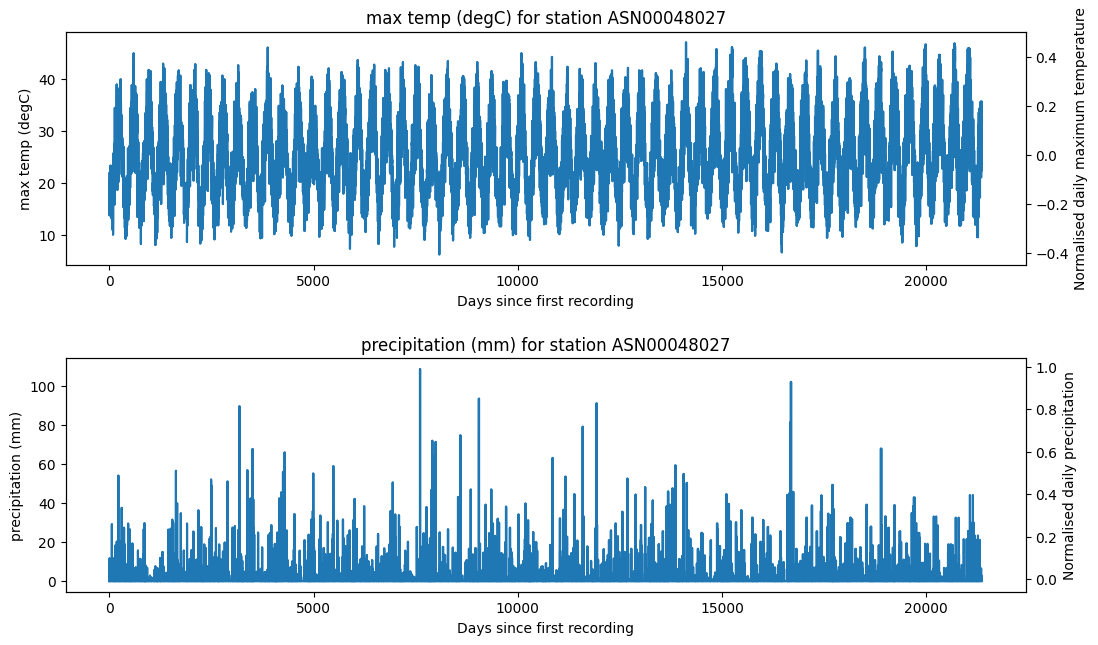

In [4]:
# normalise data, and save means and maximums for later use
tmax_normalised = tmax.normalise(tmax_vals)
tmax_mean = np.mean(tmax_vals)
tmax_max = np.max(tmax_vals)
prcp_normalised = prcp.normalise(prcp_vals)
prcp_mean = np.mean(prcp_vals)
prcp_max = np.max(prcp_vals)

# plot means and normalised means
fig, ax = plt.subplots(2, 1, figsize = (12, 7))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
ax[0].plot(tmax_dates, tmax_vals)
ax[0].set_xlabel("Days since first recording")
ax[0].set_ylabel(f"{tmax.get_label()}")
ax[0].set_title(f"{tmax.get_label()} for station {station}")
ax2 = ax[0].twinx()
ax2.plot(tmax_normalised)
ax2.set_ylabel("Normalised daily maximum temperature")

ax[1].plot(prcp_dates, prcp_vals)
ax[1].set_xlabel("Days since first recording")
ax[1].set_ylabel(f"{prcp.get_label()}")
ax[1].set_title(f"{prcp.get_label()} for station {station}")
ax2 = ax[1].twinx()
ax2.plot(prcp_normalised)
ax2.set_ylabel("Normalised daily precipitation")


In [5]:
WINDOW_SIZE = 10
OFFSET = 1

# make sure arrays are the same length
if len(tmax_normalised > len(prcp_normalised)):
    tmax_normalised = tmax_normalised[:len(prcp_normalised)]
if len(prcp_normalised > len(tmax_normalised)):
    prcp_normalised = prcp_normalised[:len(tmax_normalised)]

# join all variable arrays into one n-d array
all_vals = np.vstack((tmax_normalised, prcp_normalised)).T
print(f"Shape of combined data: {np.shape(all_vals)}")
print(all_vals[:10])

# calculate appropriate divisions of data
test_len = int(len(all_vals) * 0.2)
train_len = int(len(all_vals) * 0.7)
validate_len = int(len(all_vals) * 0.1)

print(f"Length of training data: {train_len}")
print(f"Length of validation data: {validate_len}")
print(f"Length of testing data: {test_len}")

# divide data into training, validating and testing sets
test = all_vals[:test_len,:]
train = all_vals[test_len+1:test_len+train_len,:]
validate = all_vals[test_len+train_len+1:,:]

# split data into input windows and targets
input_test, target_test = shapeArray(test, WINDOW_SIZE, OFFSET)
input_train, target_train = shapeArray(train, WINDOW_SIZE, OFFSET)
input_validate, target_validate = shapeArray(validate, WINDOW_SIZE, OFFSET)

# reshape the data into the correct format for input into the model
n_features = 2
print(f"Training input shape before reshaping: {np.shape(input_train)}")
print("Head before reshaping:")
print(input_train[:10])
input_train = input_train.reshape((input_train.shape[0], input_train.shape[1], n_features))
input_test = input_test.reshape((input_test.shape[0], input_test.shape[1], n_features))
input_validate = input_validate.reshape((input_validate.shape[0], input_validate.shape[1], n_features))
print(f"Training input shape after reshaping: {np.shape(input_train)}")
print("Head after reshaping:")
print(input_train[:10])



Shape of combined data: (21290, 2)
[[-0.07537562 -0.00981069]
 [-0.19665222  0.00857167]
 [-0.18814158 -0.00981069]
 [-0.1923969  -0.00981069]
 [-0.22005647 -0.00981069]
 [-0.14984371 -0.00981069]
 [-0.24133307  0.00857167]
 [-0.23495009  0.09772608]
 [-0.24771605  0.02511579]
 [-0.21580116 -0.00705333]]
Length of training data: 14902
Length of validation data: 2129
Length of testing data: 4258
Training input shape before reshaping: (14891, 10, 2)
Head before reshaping:
[[[ 0.05653927 -0.00061951]
  [ 0.12036906 -0.00981069]
  [ 0.17568821 -0.00981069]
  [ 0.18419884 -0.00981069]
  [ 0.14590097 -0.00981069]
  [ 0.09909246 -0.00981069]
  [ 0.06292225 -0.00981069]
  [-0.03495009 -0.00981069]
  [ 0.04802863 -0.00981069]
  [-0.04346073 -0.00889157]]

 [[ 0.12036906 -0.00981069]
  [ 0.17568821 -0.00981069]
  [ 0.18419884 -0.00981069]
  [ 0.14590097 -0.00981069]
  [ 0.09909246 -0.00981069]
  [ 0.06292225 -0.00981069]
  [-0.03495009 -0.00981069]
  [ 0.04802863 -0.00981069]
  [-0.04346073 -0.0

2023-03-22 19:35:45.254168: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 19:35:45.254288: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 19:35:45.254336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (penguin): /proc/driver/nvidia/version does not exist
2023-03-22 19:35:45.265631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          17152     
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 116,226
Trainable params: 116,226
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
466/466 [==============================] - 7s 10ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 2/50
466/466 [==============================] - 5s 10ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 3/50
466/466 [==============================] - 5s 10ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 4/50


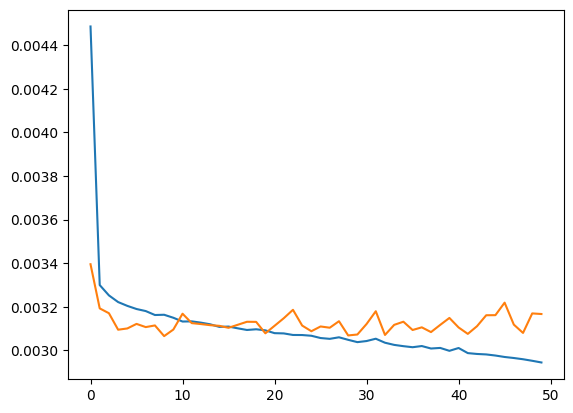

In [6]:
model = keras.models.Sequential()
model.add(layers.LSTM(64, input_shape = (None, 2), activation = 'relu', return_sequences = True))
model.add(layers.LSTM(128, activation = 'relu', return_sequences = False))
model.add(layers.Dense(2, activation = "linear"))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

model.summary()

# train model and extract final loss
history = model.fit(input_train, target_train, epochs = 50, validation_data = (input_validate, target_validate))
cost = history.history['loss']
val_cost = history.history['val_loss']

fig, ax = plt.subplots()
ax.plot(cost)
ax.plot(val_cost)

133/133 [==============================] - 1s 4ms/step
(4248, 2)


Text(0.5, 1.0, 'Observed precipitation at station ASN00048027')

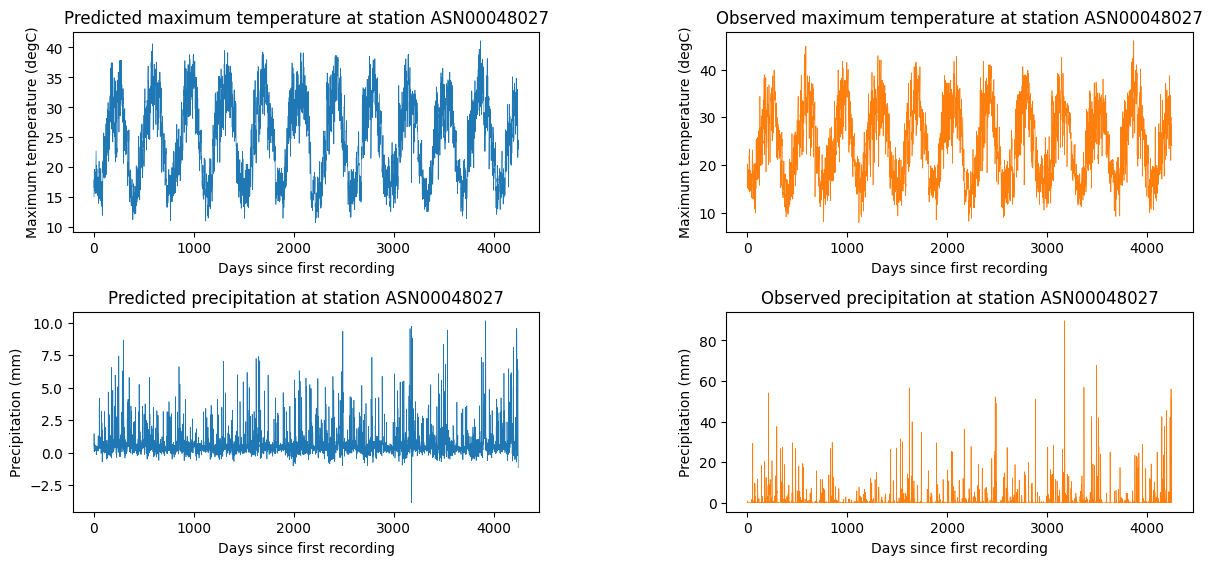

In [21]:
prediction = model.predict(input_test)
print(np.shape(prediction))

# de-normalise data for plotting
plot_target_tmax = (tmax.de_normalise(target_test[:,0], tmax_max, tmax_mean))
plot_pred_tmax = (tmax.de_normalise(prediction[:,0], tmax_max, tmax_mean))
plot_target_prcp = (prcp.de_normalise(target_test[:,1], prcp_max, prcp_mean))
plot_pred_prcp = (prcp.de_normalise(prediction[:,1], prcp_max, prcp_mean))

# plot observed and predicted data
fig, ax = plt.subplots(2,2, figsize = (14, 6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

ax[0,0].plot(plot_pred_tmax, color = 'tab:blue', linewidth = 0.5)
ax[0,0].set_xlabel("Days since first recording")
ax[0,0].set_ylabel("Maximum temperature (degC)")
ax[0,0].set_title(f"Predicted maximum temperature at station {station}")

ax[0,1].plot(plot_target_tmax, color = 'tab:orange', linewidth = 0.5)
ax[0,1].set_xlabel("Days since first recording")
ax[0,1].set_ylabel("Maximum temperature (degC)")
ax[0,1].set_title(f"Observed maximum temperature at station {station}")

ax[1,0].plot(plot_pred_prcp, color = 'tab:blue', linewidth = 0.5)
ax[1,0].set_xlabel("Days since first recording")
ax[1,0].set_ylabel("Precipitation (mm)")
ax[1,0].set_title(f"Predicted precipitation at station {station}")

ax[1,1].plot(plot_target_prcp, color = 'tab:orange', linewidth = 0.5)
ax[1,1].set_xlabel("Days since first recording")
ax[1,1].set_ylabel("Precipitation (mm)")
ax[1,1].set_title(f"Observed precipitation at station {station}")


At first glance, these appear to be very similar. Compare the first three months in more detail:

In [ ]:
print(target_test[:10, 0])
shifted_vals = shift(target_test[:,0])
print(shifted_vals[:10])

[-0.57610275 -0.29460141 -0.28119659 -0.28387755 -0.28923948 -0.41524484
 -0.52248345 -0.47958801 -0.4340116  -0.42060677]
[-0.57610275 -0.57610275 -0.29460141 -0.28119659 -0.28387755 -0.28923948
 -0.41524484 -0.52248345 -0.47958801 -0.4340116 ]


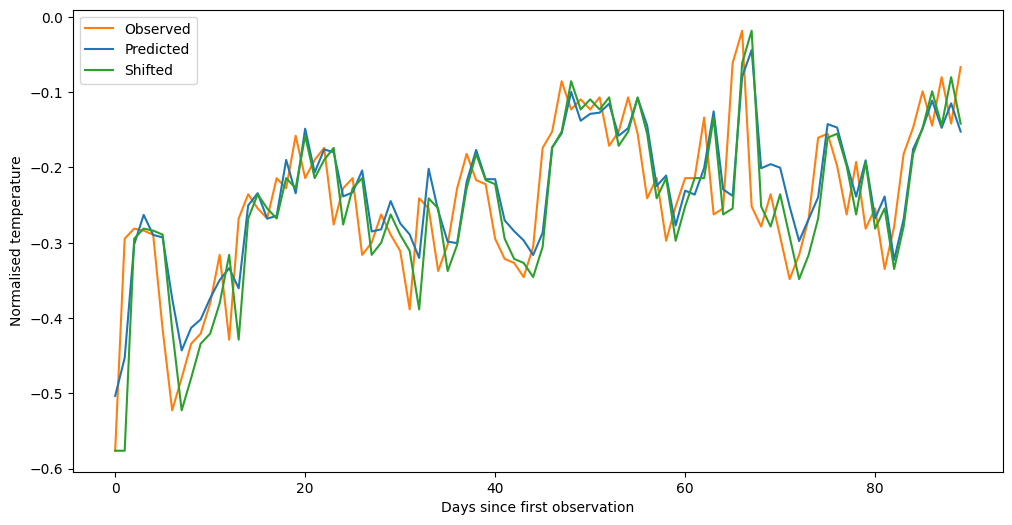

In [ ]:
months_to_plot = 3

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(target_test[:months_to_plot*30, 0], label = "Observed", color = 'tab:orange')
ax.plot(prediction[:months_to_plot*30, 0], label = "Predicted", color = 'tab:blue')
ax.plot(shifted_vals[:months_to_plot*30], label = "Shifted", color = 'tab:green')
ax.set_xlabel("Days since first observation")
ax.set_ylabel("Normalised temperature")
ax.legend()


### Least mean-squared

Sum of the squared errors.

In [ ]:
fake_mse = weather_fake_mse(vals)
print(fake_mse)


NameError: name 'vals' is not defined

## Vary the offset

In [ ]:
WINDOW_SIZE = 10
offsets = np.linspace(1, 301, 31)
costs = []
val_costs = []

for offset in offsets:
    offset = int(offset)
    # calculate appropriate divisions of data
    test_len = int(len(vals_normalised) * 0.2)
    train_len = int(len(vals_normalised) * 0.7)
    validate_len = int(len(vals_normalised) * 0.1)

    #print(f"Length of training data: {train_len}")
    #print(f"Length of validation data: {validate_len}")
    #print(f"Length of testing data: {test_len}")

    # divide data into training, validating and testing sets
    vals_test = vals_normalised[:test_len]
    vals_train = vals_normalised[test_len+1:test_len+train_len]
    vals_validate = vals_normalised[test_len+train_len+1:]

    # split data into input windows and targets
    input_test, target_test = shapeArray(vals_test, WINDOW_SIZE, offset)
    input_train, target_train = shapeArray(vals_train, WINDOW_SIZE, offset)
    input_validate, target_validate = shapeArray(vals_validate, WINDOW_SIZE, offset)

    # reshape the data into the correct format for input into the model
    n_features = 1
    #print(f"Training input shape before reshaping: {np.shape(input_train)}")
    input_train = input_train.reshape((input_train.shape[0], input_train.shape[1], n_features))
    input_test = input_test.reshape((input_test.shape[0], input_test.shape[1], n_features))
    input_validate = input_validate.reshape((input_validate.shape[0], input_validate.shape[1], n_features))
    #print(f"Training input shape after reshaping: {np.shape(input_train)}")

    model = keras.models.Sequential()
    model.add(layers.LSTM(64, input_shape = (None, 1), activation = 'relu', return_sequences = False))
    model.add(layers.Dense(1, activation = "linear"))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')

    #model.summary()

    # train model and extract final loss
    history = model.fit(input_train, target_train, epochs = 80, validation_data = (input_validate, target_validate))
    costs.append(history.history['loss'][-1])
    val_costs.append(history.history['val_loss'][-1])

fig, ax = plt.subplots()
ax.plot(offsets, costs)
ax.plot(offsets, val_costs)


Epoch 1/80
48/48 [==============================] - 1s 8ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 2/80
48/48 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.0083
Epoch 3/80
48/48 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0081
Epoch 4/80
48/48 [==============================] - 0s 5ms/step - loss: 0.0066 - val_loss: 0.0078
Epoch 5/80
48/48 [==============================] - 0s 5ms/step - loss: 0.0064 - val_loss: 0.0076
Epoch 6/80
48/48 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 0.0076
Epoch 7/80
48/48 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0073
Epoch 8/80
48/48 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0074
Epoch 9/80
48/48 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 10/80
48/48 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0069
Epoch 11/80
48/48 [

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

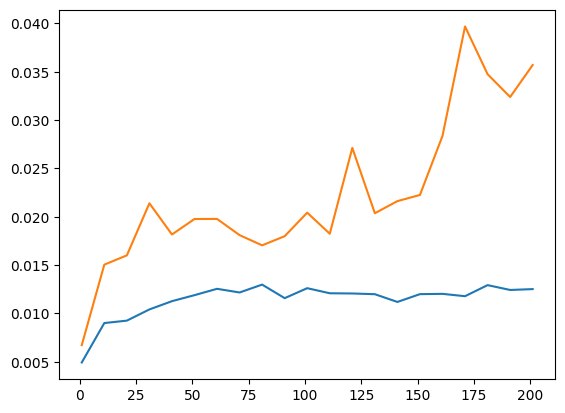

In [ ]:
fig, ax = plt.subplots()
ax.plot(offsets[:len(costs)], costs)
ax.plot(offsets[:len(val_costs)], val_costs)